# Feature Engineering

---

1. Import packages
2. Load data
3. Feature engineering

---

## 1. Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

---
## 2. Load data

In [2]:
df = pd.read_csv('./../data/client_data.csv')
df["date_activ"] = pd.to_datetime(df["date_activ"], format='%Y-%m-%d')
df["date_end"] = pd.to_datetime(df["date_end"], format='%Y-%m-%d')
df["date_modif_prod"] = pd.to_datetime(df["date_modif_prod"], format='%Y-%m-%d')
df["date_renewal"] = pd.to_datetime(df["date_renewal"], format='%Y-%m-%d')
print(df['churn'])

0        1
1        0
2        0
3        0
4        0
        ..
14601    0
14602    1
14603    1
14604    0
14605    0
Name: churn, Length: 14606, dtype: int64


In [3]:
df.head(3)



,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,t,0.0,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,f,0.0,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,f,0.0,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0


---

## 3. Feature engineering

### Difference between off-peak prices in December and preceding January

Below is the code created by your colleague to calculate the feature described above. Use this code to re-create this feature and then think about ways to build on this feature to create features with a higher predictive power.

In [4]:
price_df = pd.read_csv('./../data/price_data.csv')
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')
price_df.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


In [5]:
# group off-peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()

# get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# calculate the difference
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
diff = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]
diff.head()

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001


In [6]:
df = pd.merge(df, diff, on='id', how='left')

print(df.shape)

(14606, 28)


0        1
1        0
2        0
3        0
4        0
        ..
14601    0
14602    1
14603    1
14604    0
14605    0
Name: churn, Length: 14606, dtype: int64


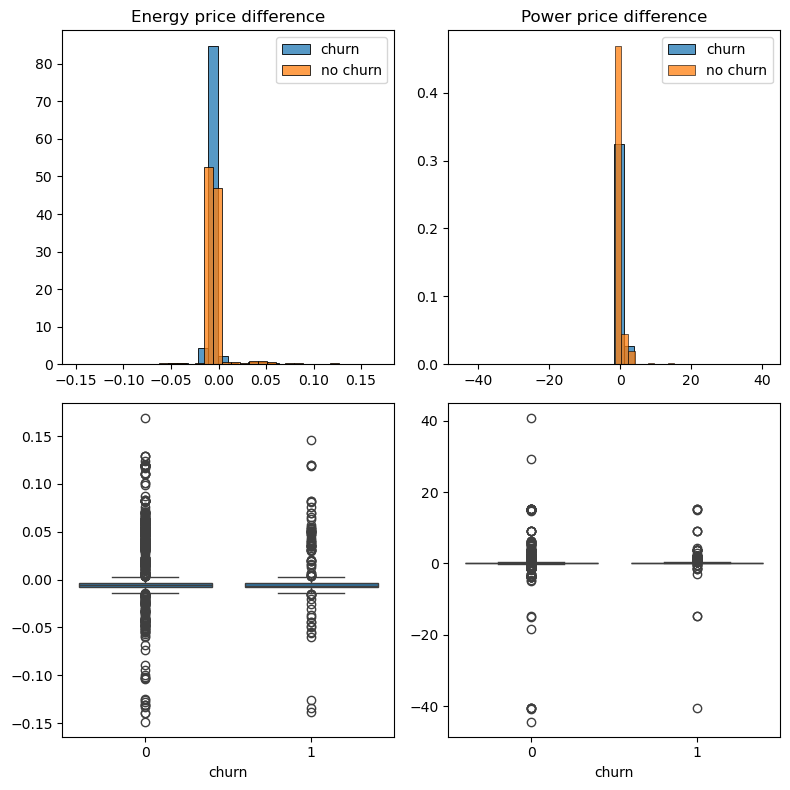

In [7]:
print(df['churn'])

# plot the distribution of the difference by churn
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

# energy price difference - histogram
sns.histplot(data=df.loc[df['churn'] == 0], x='offpeak_diff_dec_january_energy', stat='density', ax=axes[0, 0], bins=30, label='churn')
sns.histplot(data=df.loc[df['churn'] == 1], x='offpeak_diff_dec_january_energy', stat='density', ax=axes[0, 0], bins=30, label='no churn')
axes[0, 0].set_title('Energy price difference')
axes[0, 0].legend()
axes[0, 0].set_xlabel('')
axes[0, 0].set_ylabel('')

# power price difference - histogram
sns.histplot(data=df.loc[df['churn'] == 0], x='offpeak_diff_dec_january_power', stat='density', ax=axes[0, 1], bins=30, label='churn')
sns.histplot(data=df.loc[df['churn'] == 1], x='offpeak_diff_dec_january_power', stat='density', ax=axes[0, 1], bins=30, label='no churn')
axes[0, 1].legend()
axes[0, 1].set_title('Power price difference')
axes[0, 1].legend()
axes[0, 1].set_xlabel('')
axes[0, 1].set_ylabel('')

# energy price difference - boxplot
sns.boxplot(data=df, x='churn', y='offpeak_diff_dec_january_energy', ax=axes[1, 0])
axes[1, 0].set_ylabel('')

# power price difference - boxplot
sns.boxplot(data=df, x='churn', y='offpeak_diff_dec_january_power', ax=axes[1, 1])
axes[1, 1].set_ylabel('')

plt.tight_layout()
plt.show()






In [8]:
# check if there are any missing values
print(df.shape)

(14606, 28)


<AxesSubplot:xlabel='offpeak_diff_dec_january_energy', ylabel='offpeak_diff_dec_january_power'>

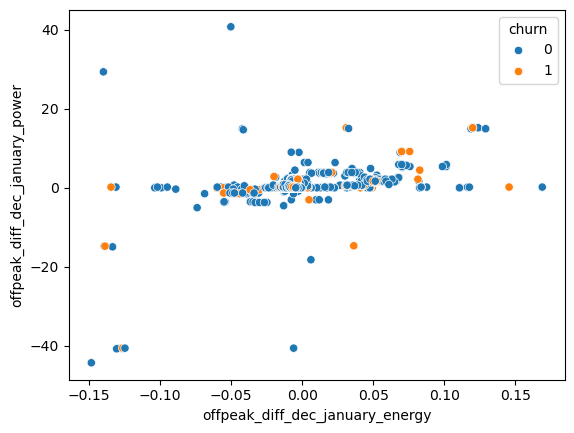

In [9]:
# scatter plot of the difference by churn
sns.scatterplot(data=df, x='offpeak_diff_dec_january_energy', y='offpeak_diff_dec_january_power', hue='churn')

##### Categorical values

In [10]:

other_companies = df['origin_up'].value_counts().loc[lambda x: x < 10].index.tolist()

# replace them with 'other'
df['origin_up'].replace(other_companies, 'other', inplace=True)

df['origin_up'].value_counts()



lxidpiddsbxsbosboudacockeimpuepw    7097
kamkkxfxxuwbdslkwifmmcsiusiuosws    4294
ldkssxwpmemidmecebumciepifcamkci    3148
MISSING                               64
other                                  3
Name: origin_up, dtype: int64

In [11]:
other_num_years = df['num_years_antig'].value_counts().loc[lambda x: x < 20].index.tolist()

# replace them with 'other'
df['num_years_antig'].replace(other_num_years, 'other', inplace=True)

df['num_years_antig'].value_counts()

6        4769
4        3982
3        2433
5        2317
7         509
11        185
12        110
8         103
9          92
10         81
other      25
Name: num_years_antig, dtype: int64

In [12]:
df['channel_sales'].value_counts()

other_channel_sales = df['channel_sales'].value_counts().loc[lambda x: x < 20].index.tolist()

# replace them with 'other'
df['channel_sales'].replace(other_channel_sales, 'other', inplace=True)

df['channel_sales'].value_counts()



foosdfpfkusacimwkcsosbicdxkicaua    6754
MISSING                             3725
lmkebamcaaclubfxadlmueccxoimlema    1843
usilxuppasemubllopkaafesmlibmsdf    1375
ewpakwlliwisiwduibdlfmalxowmwpci     893
other                                 16
Name: channel_sales, dtype: int64

##### Drop dates

In [13]:
df.drop(columns=['date_activ', 'date_modif_prod', 'date_renewal', 'date_end', 'margin_gross_pow_ele', 'cons_12m', 'forecast_cons_12m', 'forecast_cons_year'], inplace=True)

df.head()

,id,channel_sales,cons_gas_12m,cons_last_month,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,54946,0,0.0,1.78,0.114481,0.098142,40.606701,t,0.00,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1,0.020057,3.700961
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,0,0,0.0,16.27,0.145711,0.000000,44.311378,f,0.00,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0,-0.003767,0.177779
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,0,0,0.0,38.72,0.165794,0.087899,44.311378,f,0.00,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0,-0.004670,0.177779
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,0,0,0.0,19.83,0.146694,0.000000,44.311378,f,0.00,30.22,1,25.46,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,0,-0.004547,0.177779
4,149d57cf92fc41cf94415803a877cb4b,MISSING,0,526,0.0,131.73,0.116900,0.100015,40.606701,f,52.32,44.91,1,47.98,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,19.800,0,-0.006192,0.162916


In [14]:
print(df['churn'].shape)

(14606,)


In [15]:
# check how many columns

print(df.shape)


(14606, 20)


In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve

def print_scores(y_true, y_pred):
    print(f'Accuacy: {accuracy_score(y_true, y_pred):.2f}')
    print(f'Precision: {precision_score(y_true, y_pred, zero_division=0):.2f}')
    print(f'Recall: {recall_score(y_true, y_pred, zero_division=0):.2f}')
    print(f'F1: {f1_score(y_true, y_pred, zero_division=0):.2f}')


In [124]:
from sklearn.model_selection import train_test_split

X = pd.get_dummies(df.drop(columns='churn'))
y = df.churn

# perform pca on the data

from sklearn.decomposition import PCA

pca = PCA(n_components=3)

X_pca = pca.fit_transform(X)

#  see the importance of each component

print(pca.explained_variance_ratio_)

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=.2, stratify=y, random_state=42)


[9.04073697e-01 9.59193598e-02 4.93778618e-06]


In [125]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42))
])

pipeline.fit(X_train, y_train)

y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)

print('Train scores:')

print_scores(y_train, y_pred_train)


print()
print('Test scores:')
print_scores(y_test, y_pred_test)


Train scores:
Accuacy: 0.97
Precision: 1.00
Recall: 0.71
F1: 0.83

Test scores:
Accuacy: 0.90
Precision: 0.33
Recall: 0.04
F1: 0.07


> We are making good results on the train set, but not on the test set. This is a sign of overfitting. We need to adjust our hyperparameters to reduce overfitting.

In [166]:
# randomized search

from sklearn.model_selection import RandomizedSearchCV

# define the parameters

param_grid = {
    'rf__n_estimators': [20],
    'rf__max_depth': [50],
    'rf__min_samples_split': [1, 10, 15, 20],
    'rf__min_samples_leaf': [5, 10, 15],
    'rf__max_features': ['log2'],

}



search = RandomizedSearchCV(pipeline, param_grid, n_iter=10, scoring='f1', n_jobs=-1, cv=5, verbose=1, random_state=42)

search.fit(X_train, y_train)

# test scores

y_pred_train = search.predict(X_train)

y_pred_test = search.predict(X_test)

print('Train scores:')

print_scores(y_train, y_pred_train)


print()

print('Test scores:')

print_scores(y_test, y_pred_test)

# get the best parameters

search.best_params_



Fitting 5 folds for each of 10 candidates, totalling 50 fits
Train scores:
Accuacy: 0.90
Precision: 1.00
Recall: 0.02
F1: 0.04

Test scores:
Accuacy: 0.90
Precision: 1.00
Recall: 0.01
F1: 0.02


{'rf__n_estimators': 20,
 'rf__min_samples_split': 1,
 'rf__min_samples_leaf': 5,
 'rf__max_features': 'log2',
 'rf__max_depth': 50}

> After adjusting the hyperparameters, we have a good accuracy and precision this mean that we are preddicting well the positive values. But we have a low recall, this mean that we are not predicting well the negative values. THis mean that the price feature is not a very good feature to predict the churn it may help but we maybe need to demand more features.